In [ ]:
import os
import cv2 as cv
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_dir = '/content/drive/MyDrive/Dataset/Bone Cancer Data Set'


In [ ]:
CATEGORIES = os.listdir(DATASET_dir)


image_shapes = set()
total_images = 0


DATA = []
for c in CATEGORIES:
    path = os.path.join(DATASET_dir, c)
    class_num = CATEGORIES.index(c)

    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img))

        if img_arr is not None:
            img_arr_resized = cv.resize(img_arr, (375, 375))  # Resize to 375x375
            total_images += 1
            image_shapes.add(img_arr_resized.shape)
            DATA.append([img_arr_resized, class_num])
        else:
            print(f"Failed to load {img}")


100%|██████████| 292/292 [00:10<00:00, 27.12it/s]


In [ ]:
print(CATEGORIES)

['Non-Tumor', 'Non-Viable-Tumor', 'Viable']


In [ ]:


print("Total number of images loaded:", total_images)


if len(image_shapes) == 1:
    shape = image_shapes.pop()
    print(f"All images have the same shape: {shape}")
else:
    print("Images have different shapes.")

Total number of images loaded: 1144
All images have the same shape: (375, 375, 3)


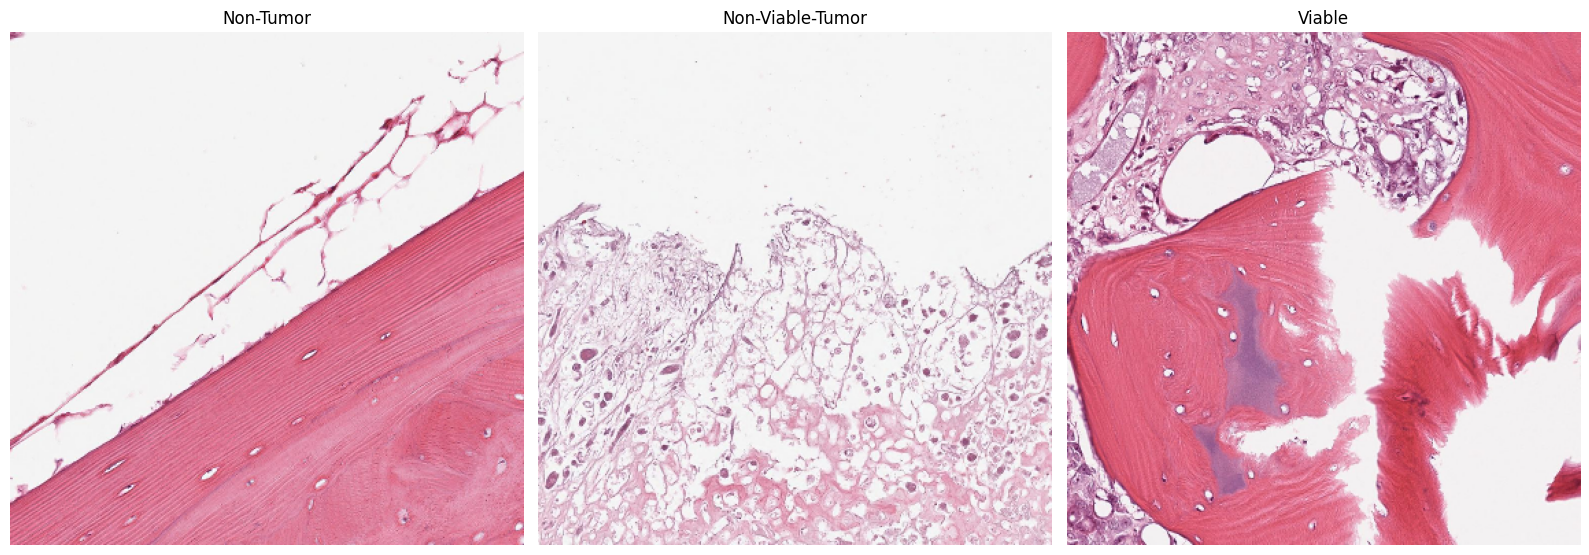

In [ ]:
plt.figure(figsize=(16, 6))
for i, c in enumerate(CATEGORIES):
    category_images = [item[0] for item in DATA if item[1] == CATEGORIES.index(c)]
    random_image = random.choice(category_images)

    plt.subplot(1, len(CATEGORIES), i + 1)
    plt.imshow(cv.cvtColor(random_image, cv.COLOR_BGR2RGB))
    plt.title(c)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

save_dir = '/content/drive/MyDrive/ResizedImages'


if not os.path.exists(save_dir):
    os.makedirs(save_dir)


for c in CATEGORIES:
    category_save_dir = os.path.join(save_dir, c)
    if not os.path.exists(category_save_dir):
        os.makedirs(category_save_dir)

    category_images = [img_data[0] for img_data in DATA if CATEGORIES[img_data[1]] == c]

    for i, img in enumerate(category_images):
        filename = f"{c}_{i + 1}.jpg"
        save_path = os.path.join(category_save_dir, filename)
        cv.imwrite(save_path, img)
print("All Resized Images are Saved")

All Resized Images are Saved


In [ ]:
dataset_dir = '/content/drive/MyDrive/ResizedImages'
save_dir = '/content/drive/MyDrive/SplitImages'

In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

train_dir = os.path.join(save_dir, 'train')
val_dir = os.path.join(save_dir, 'validation')
test_dir = os.path.join(save_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


categories = os.listdir(dataset_dir)


train_data = {category: [] for category in categories}
val_data = {category: [] for category in categories}
test_data = {category: [] for category in categories}


for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    filenames = os.listdir(category_dir)

    train_files, remaining_files = train_test_split(filenames, train_size=0.7, random_state=42)
    val_files, test_files = train_test_split(remaining_files, test_size=0.2, random_state=42)

    train_data[category].extend(train_files)
    val_data[category].extend(val_files)
    test_data[category].extend(test_files)


def copy_images(data, source_dir, dest_dir):
    for class_name, filenames in data.items():
        class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for filename in filenames:
            src_path = os.path.join(source_dir, class_name, filename)
            dest_path = os.path.join(class_dir, filename)
            shutil.copy(src_path, dest_path)


copy_images(train_data, dataset_dir, train_dir)
copy_images(val_data, dataset_dir, val_dir)
copy_images(test_data, dataset_dir, test_dir)

print("Number of images in training set:", sum(len(filenames) for filenames in train_data.values()))
print("Number of images in validation set:", sum(len(filenames) for filenames in val_data.values()))
print("Number of images in testing set:", sum(len(filenames) for filenames in test_data.values()))


Number of images in training set: 800
Number of images in validation set: 274
Number of images in testing set: 70


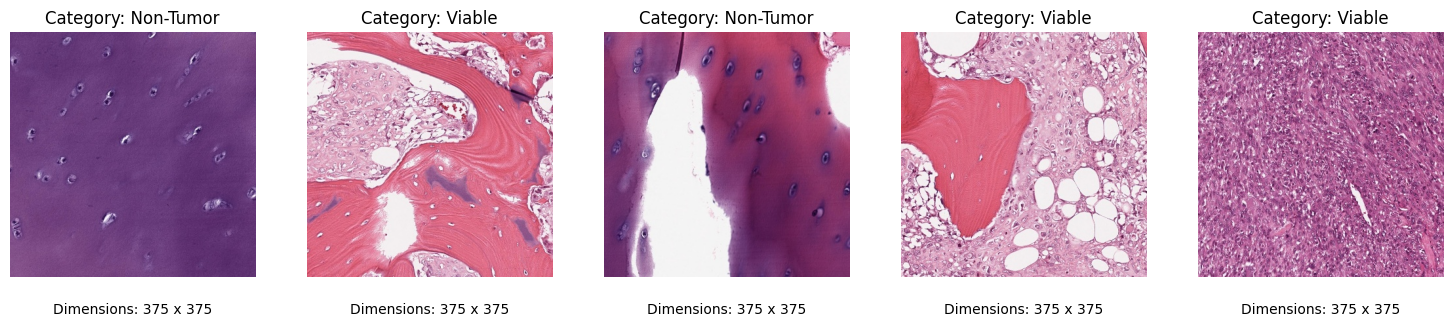

In [ ]:
import matplotlib.pyplot as plt
import random


num_images_to_display = 5


num_columns = num_images_to_display
num_rows = 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3))


for i in range(num_images_to_display):
    ax = axes[i]


    random_category = random.choice(list(train_data.keys()))
    random_image = random.choice(train_data[random_category])

    image_path = os.path.join(train_dir, random_category, random_image)

    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(f"Category: {random_category}")
    ax.axis('off')

    height, width, _ = img.shape
    ax.text(0.5, -0.15, f"Dimensions: {width} x {height}", transform=ax.transAxes, ha='center', color='black')

plt.tight_layout()
plt.show()


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2 as cv
import numpy as np


augmented_save_dir = '/content/drive/MyDrive/Augmented_Patches'

if not os.path.exists(augmented_save_dir):
    os.makedirs(augmented_save_dir)

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

patch_size = (128, 128)
total_num_patches = 56929

train_image_dir = '/content/drive/MyDrive/SplitImages/train'

classes = os.listdir(train_image_dir)

desired_images_per_class = total_num_patches // len(classes)

class_augmented_dirs = {
    "Non-Tumor": os.path.join(augmented_save_dir, "Non Tumor Augmented"),
    "Viable": os.path.join(augmented_save_dir, "Viable Augmented"),
    "Non-Viable-Tumor": os.path.join(augmented_save_dir, "Non Viable Augmented")
}

for class_name in classes:
    class_save_dir = class_augmented_dirs[class_name]

    if not os.path.exists(class_save_dir):
        os.makedirs(class_save_dir)

    all_images = []

    class_dir = os.path.join(train_image_dir, class_name)
    image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]

    for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.resize(image, patch_size)
        all_images.append(image)


    augmented_images = datagen.flow(np.array(all_images), batch_size=1, shuffle=False)

    for i in range(desired_images_per_class):
        augmented_img = augmented_images.next()[0]
        patch_index = i + 1
        filename = f"augmented_patch_{patch_index}.jpg"
        save_path = os.path.join(class_save_dir, filename)
        cv.imwrite(save_path, (augmented_img * 255).astype(np.uint8))

        print(f"Generated augmented patch {patch_index} for class: {class_name}")


last_class_name = classes[-1]
last_class_save_dir = class_augmented_dirs[last_class_name]
remaining_images = total_num_patches - (desired_images_per_class * len(classes))

all_images = []

class_dir = os.path.join(train_image_dir, last_class_name)
image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]

for image_path in image_paths:
    image = cv.imread(image_path)
    image = cv.resize(image, patch_size)
    all_images.append(image)


augmented_images = datagen.flow(np.array(all_images), batch_size=1, shuffle=False)

for i in range(remaining_images):
    augmented_img = augmented_images.next()[0]
    patch_index = i + 1 + (desired_images_per_class * len(classes))
    filename = f"augmented_patch_{patch_index}.jpg"
    save_path = os.path.join(last_class_save_dir, filename)
    cv.imwrite(save_path, (augmented_img * 255).astype(np.uint8))

    print(f"Generated augmented patch {patch_index} for class: {last_class_name}")


total_generated_images = sum(len(os.listdir(class_augmented_dirs[class_name])) for class_name in classes)
print("Total augmented images generated:", total_generated_images)


Streaming output truncated to the last 5000 lines.
Generated augmented patch 13979 for class: Viable
Generated augmented patch 13980 for class: Viable
Generated augmented patch 13981 for class: Viable
Generated augmented patch 13982 for class: Viable
Generated augmented patch 13983 for class: Viable
Generated augmented patch 13984 for class: Viable
Generated augmented patch 13985 for class: Viable
Generated augmented patch 13986 for class: Viable
Generated augmented patch 13987 for class: Viable
Generated augmented patch 13988 for class: Viable
Generated augmented patch 13989 for class: Viable
Generated augmented patch 13990 for class: Viable
Generated augmented patch 13991 for class: Viable
Generated augmented patch 13992 for class: Viable
Generated augmented patch 13993 for class: Viable
Generated augmented patch 13994 for class: Viable
Generated augmented patch 13995 for class: Viable
Generated augmented patch 13996 for class: Viable
Generated augmented patch 13997 for class: Viable

In [ ]:
import os

augmented_save_dir = '/content/drive/MyDrive/Augmented_Patches'


def count_images_in_directory(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif')
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_count += 1
    return image_count


total_images = count_images_in_directory(augmented_save_dir)
print("Number of images in the directory:", total_images)


Number of images in the directory: 56929


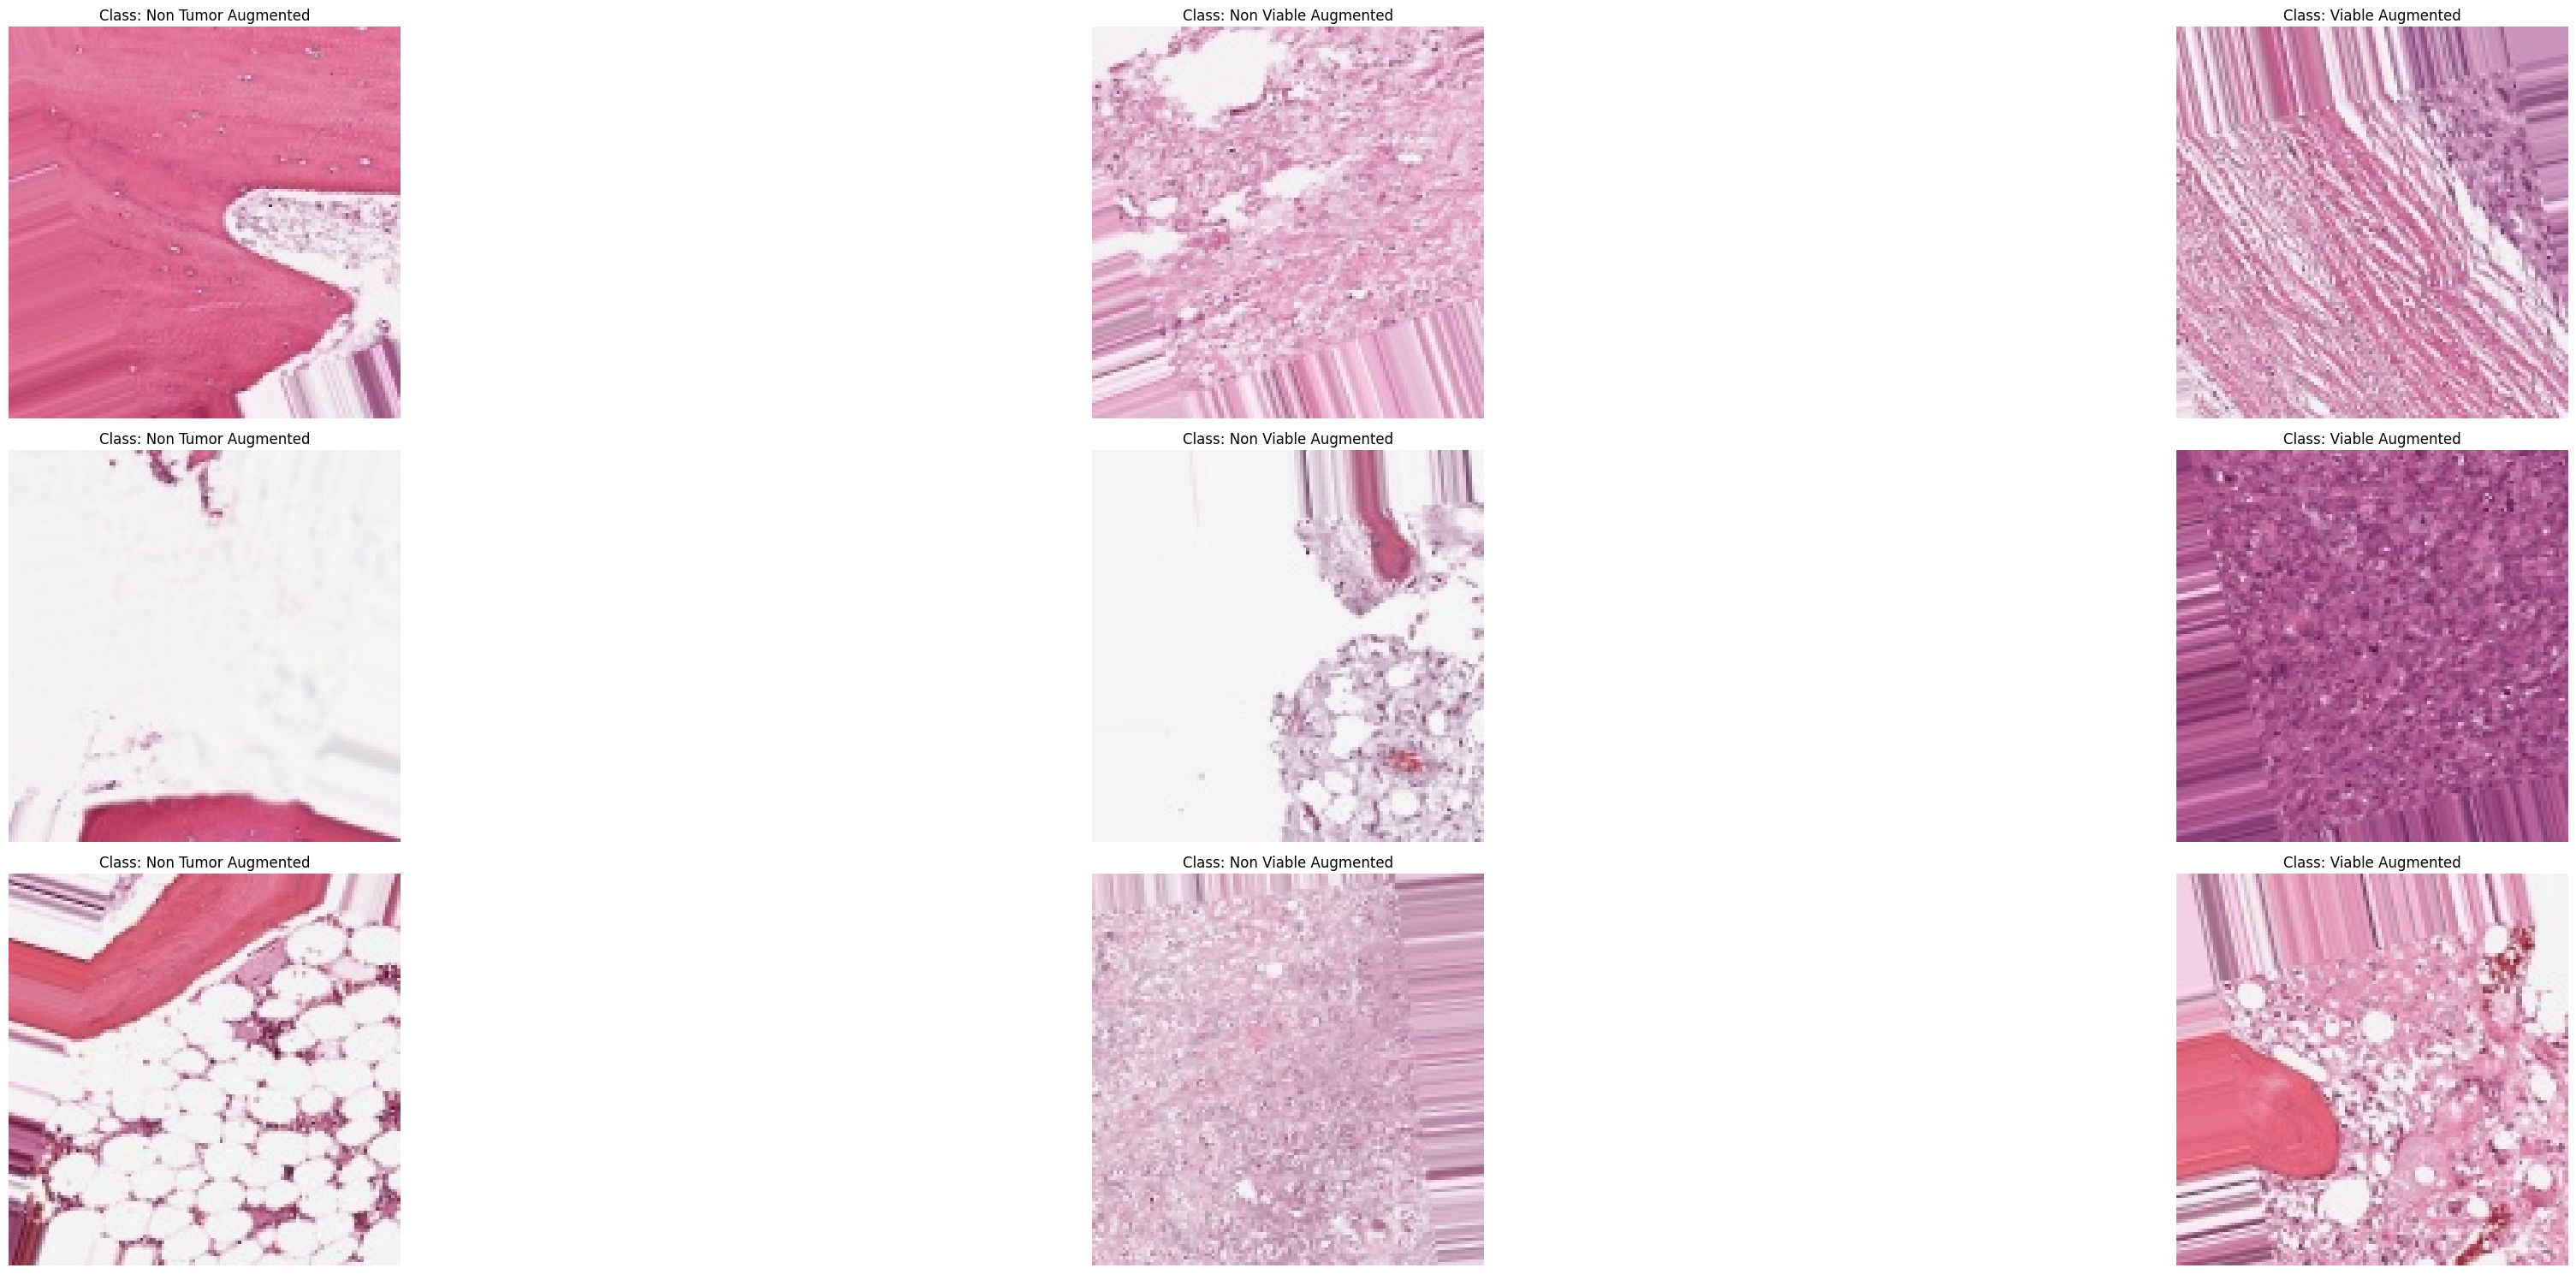

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt


augmented_save_dir = '/content/drive/MyDrive/Augmented_Patches'


classes = os.listdir(augmented_save_dir)

num_images_per_class = 3

num_columns = len(classes) * num_images_per_class


plt.figure(figsize=(15 * len(classes), 5 * num_images_per_class))


for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(augmented_save_dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg'))]


    for i in range(num_images_per_class):
        image_path = os.path.join(class_dir, image_files[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(num_images_per_class, len(classes), i * len(classes) + class_idx + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis('off')


plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image


augmented_save_dir = '/content/drive/MyDrive/Augmented_Patches'
resized_save_dir = '/content/drive/MyDrive/ResizedAugmentedImages'


categories = [category for category in os.listdir(augmented_save_dir) if os.path.isdir(os.path.join(augmented_save_dir, category))]
print(categories)


['Non Tumor Augmented', 'Non Viable Augmented', 'Viable Augmented']


In [ ]:
import os


non_tumor_augmented_dir = os.path.join(augmented_save_dir, 'Non Tumor Augmented')


image_files = os.listdir(non_tumor_augmented_dir)


for image_file in image_files:
    print(image_file)
    break


total_images = len(image_files)
print(f"Total number of images in '{non_tumor_augmented_dir}': {total_images}")


augmented_patch_17977.jpg
Total number of images in '/content/drive/MyDrive/Augmented_Patches/Non Tumor Augmented': 18976


In [ ]:
import os


non_tumor_augmented_dir = os.path.join(augmented_save_dir, 'Non Viable Augmented')


image_files = os.listdir(non_tumor_augmented_dir)


image_files.sort()


if image_files:

    first_image_name = image_files[0]
    print(f"First image name in '{non_tumor_augmented_dir}': {first_image_name}")
else:
    print("No image files found in the directory.")


total_images = len(image_files)
print(f"Total number of images in '{non_tumor_augmented_dir}': {total_images}")


First image name in '/content/drive/MyDrive/Augmented_Patches/Non Viable Augmented': augmented_patch_1.jpg
Total number of images in '/content/drive/MyDrive/Augmented_Patches/Non Viable Augmented': 18976


In [2]:
import os
from PIL import Image


non_tumor_augmented_dir = '/content/drive/MyDrive/Augmented_Patches/Non Tumor Augmented'


resized_save_dir = '/content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped'


main_dir_name = os.path.basename(non_tumor_augmented_dir)


os.makedirs(resized_save_dir, exist_ok=True)


resized_main_dir = os.path.join(resized_save_dir, main_dir_name)
os.makedirs(resized_main_dir, exist_ok=True)


image_files = os.listdir(non_tumor_augmented_dir)


def sort_by_image_number(image_file):
    image_number = int(image_file.split('_')[2].split('.')[0])
    return image_number


image_files.sort(key=sort_by_image_number)


for image_file in image_files:
    image_path = os.path.join(non_tumor_augmented_dir, image_file)
    resized_image_path = os.path.join(resized_main_dir, image_file)


    img = Image.open(image_path)
    img_resized = img.resize((375, 375))


    img_resized.save(resized_image_path)

    print(f"Resized and saved {image_file} in {resized_main_dir}")

print("Resizing and saving completed.")


Streaming output truncated to the last 5000 lines.
Resized and saved augmented_patch_13978.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13979.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13980.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13981.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13982.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13983.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented
Resized and saved augmented_patch_13984.jpg in /content/drive/MyDrive/ResizedAugmentedImages/Non-

In [5]:
resized_save_dir = '/content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented'


file_list = os.listdir(resized_save_dir)


image_extensions = ['.jpg']
image_count = sum(1 for file in file_list if os.path.splitext(file)[1].lower() in image_extensions)

print(f"Number of images in the directory: {image_count}")


Number of images in the directory: 18976


In [6]:
from PIL import Image
import os

resized_save_dir = '/content/drive/MyDrive/ResizedAugmentedImages/Non-Tumor-Augmented-Reshaped/Non Tumor Augmented'


file_list = os.listdir(resized_save_dir)


image_extensions = ['.jpg']


common_dimensions = None


for file in file_list:
    _, file_extension = os.path.splitext(file)
    if file_extension.lower() in image_extensions:
        image_path = os.path.join(resized_save_dir, file)
        img = Image.open(image_path)
        width, height = img.size


        if common_dimensions is None:
            common_dimensions = (width, height)
        else:
            if (width, height) != common_dimensions:
                print("Images have different dimensions.")
                break

if common_dimensions:
    print(f"All images have the same dimensions: {common_dimensions[0]} x {common_dimensions[1]}")


All images have the same dimensions: 375 x 375
